In [2]:
import tensorflow as tf
from utils import create_session_config
import tensorflow_probability as tp
import numpy as np
from models.utils import covariance,correlation_matrix,tf_cov,assert_cov_positive_definite,corr
from models.nn_pdf_common import transform_x,density_estimator
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import norm
from flags import FLAGS

/home/pawel/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pawel/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pawel/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pawel/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/pawel/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
def log_likelihood_from_cdfs_transforms(cov_type, cdfs, lls, x, params):
    res={}
    ll_marginals_sum = tf.reshape(tf.reduce_sum(tf.concat(lls, axis=1), axis=1), [-1, 1])
    if len(lls) == 1:
        res['log_likelihood'] = ll_marginals_sum
        return res

    quantiles = []
    std_normal = tp.distributions.Normal(loc=0., scale=1.)
    for i, cdf in enumerate(cdfs):
        with tf.variable_scope("quantile_%d" % i):
            quantiles.append(std_normal.quantile(cdf, name="quantile"))
            res["quantile_%d" % i] = tf.Print(quantiles[-1], [tf.train.get_global_step() ,tf.reduce_mean(std_normal.log_prob(quantiles[-1]))], message='quantile_log_prob') 
            
    quantiles_combined = tf.concat(quantiles, axis=1, name="quantiles_combined")

    if cov_type=="param_cov":
        cov = covariance(x, len(cdfs), params)
        cor = correlation_matrix(cov)
    elif cov_type=="const_cov":
        cov = tf_cov(quantiles_combined)
        cov = assert_cov_positive_definite(cov)
        cor = corr(cov)
        cor = tf.expand_dims(cor, axis=0)
    else:
        raise ValueError("Not recognized covariance type: %s"%cov_type)

#     c_pdf = tp.distributions.MultivariateNormalFullCovariance(loc=tf.constant([0.0] * len(cdfs)),
#                                                               covariance_matrix=cor)
    
#     c_pdf_log_prob = tf.reshape(c_pdf.log_prob(tf.stop_gradient(quantiles_combined)), [-1, 1], name="copula_log_prob")
    
    c_pdf_log_prob = -tf.log(tf.sqrt(tf.matrix_determinant(cor)))
    inv_cor_min_eye = tf.matrix_inverse(cor) - tf.eye(len(cdfs))
    inv_cor_min_eye = tf.tile(inv_cor_min_eye,
                              [tf.div(tf.shape(quantiles_combined)[0], tf.shape(inv_cor_min_eye)[0]), 1, 1])
    c_pdf_log_exponent = tf.matmul(tf.expand_dims(quantiles_combined, axis=1), inv_cor_min_eye)
    c_pdf_log_exponent = - 0.5 * tf.matmul(c_pdf_log_exponent, tf.expand_dims(quantiles_combined, axis=-1))
    c_pdf_log_exponent = tf.reshape(c_pdf_log_exponent, [-1, 1])
    c_pdf_log_prob = tf.reshape(c_pdf_log_prob, [-1,1]) + c_pdf_log_exponent
    
#     res['log_likelihood']inv_cor_min_eye= = tf.cond(tf.less(tf.train.get_global_step(),tf.constant(1000)), 
#                                     lambda : ll_marginals_sum, 
#                                     lambda: c_pdf_log_prob + ll_marginals_sum) 
    res['log_likelihood'] = c_pdf_log_prob + ll_marginals_sum
#     res['log_likelihood'] = tf.Print(res['log_likelihood'],[res['log_likelihood']], message="shape: ")
    
    res['cov']=cov
    res['cor']=cor
    return res

def marginals_and_joint(cov_type, cdfs, pdfs,x, params):
    predictions={}
    lls = []

    for i, cdf, pdf in zip(range(len(pdfs)), cdfs, pdfs):
        predictions["cdf%d" % i] = cdf
        predictions["pdf%d" % i] = pdf
        lls.append(tf.log(pdf))

    predictions.update(log_likelihood_from_cdfs_transforms(cov_type, cdfs, lls,x, params))
    return predictions

In [7]:
x_norm=np.linspace(norm.ppf(0.01), norm.ppf(0.99),100)
pdf_norm = norm.pdf(x_norm)

true_cov: [[ 1.   3.5]
 [ 3.5 25. ]]
global step 0
true_loss:  4.109136
loss:  6.6310453
cor:  [[[1.        0.6454496]
  [0.6454496 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


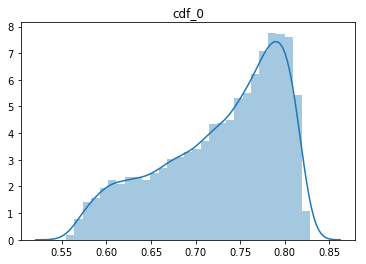

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


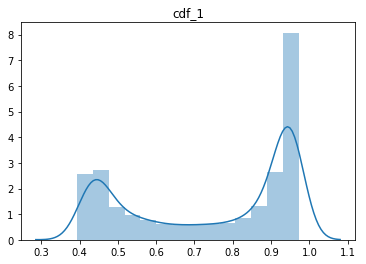

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


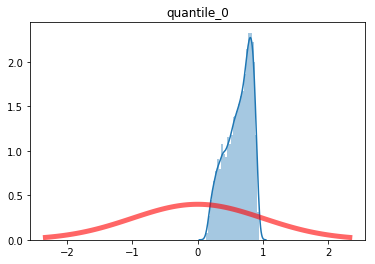

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


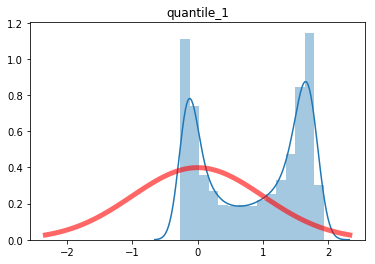

global step 1
loss: 6.626215
cor:  [[[1.        0.6608129]
  [0.6608129 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


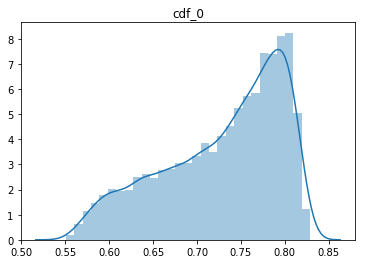

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


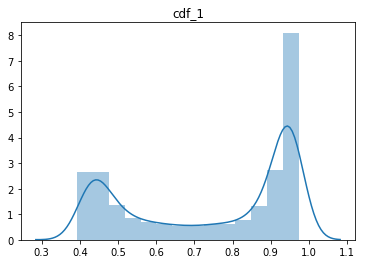

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


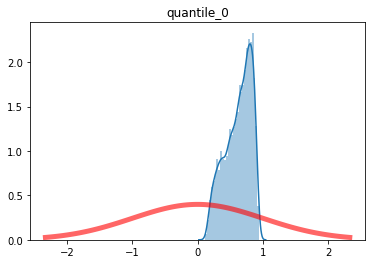

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


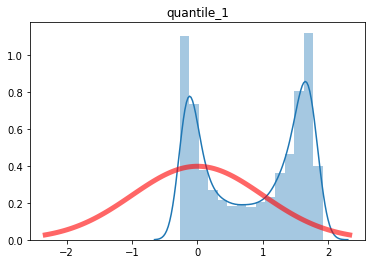

global step 101
loss: 5.336581
cor:  [[[1.        0.6626932]
  [0.6626932 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


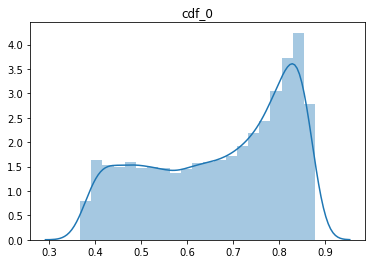

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


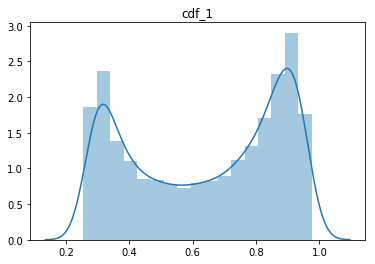

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


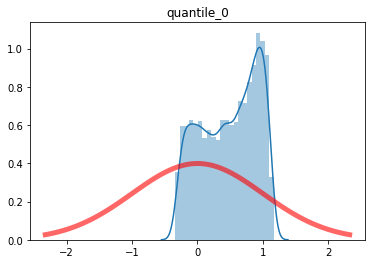

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


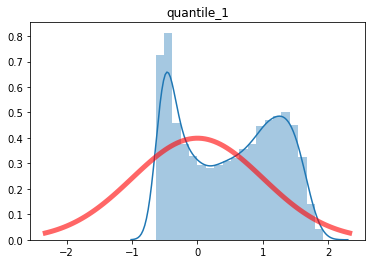

global step 201
loss: 4.7540283
cor:  [[[1.         0.68516546]
  [0.68516546 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


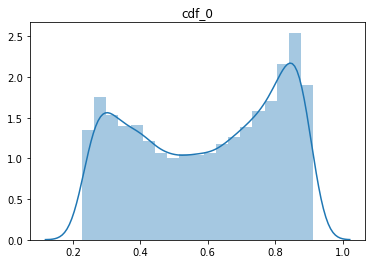

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


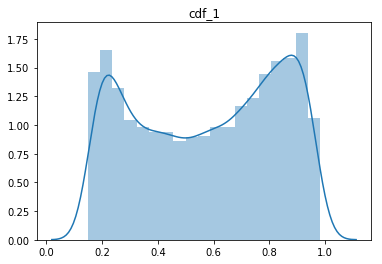

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


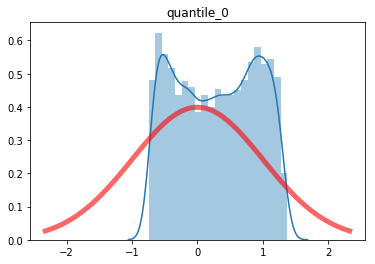

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


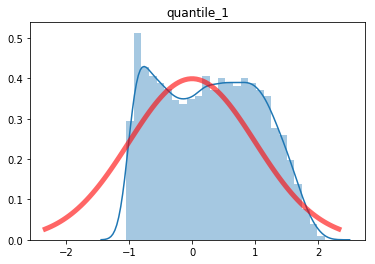

global step 301
loss: 4.5094566
cor:  [[[1.        0.6835064]
  [0.6835064 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


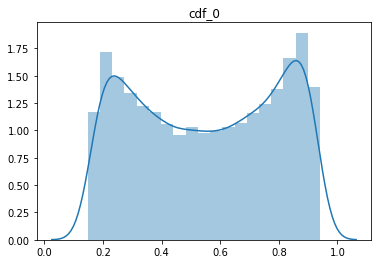

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


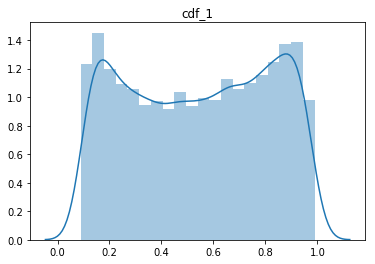

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


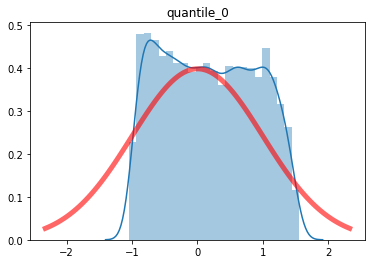

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


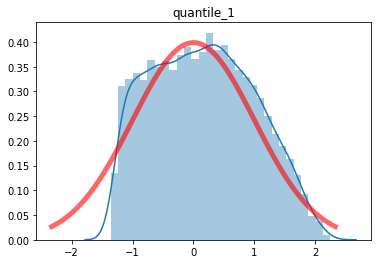

global step 401
loss: 4.3723307
cor:  [[[1.        0.6822841]
  [0.6822841 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


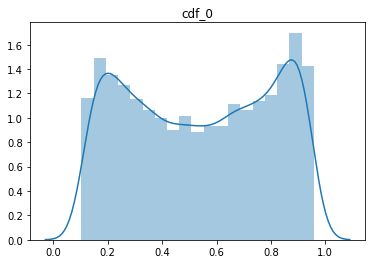

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


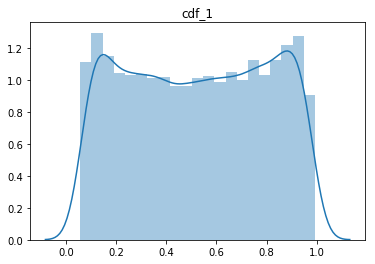

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


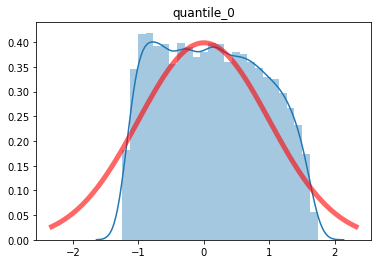

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


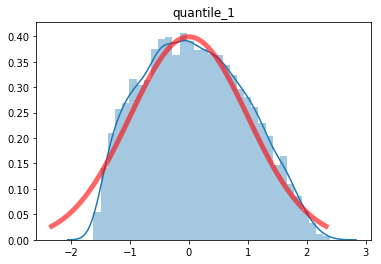

global step 501
loss: 4.296885
cor:  [[[1.        0.6924902]
  [0.6924902 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


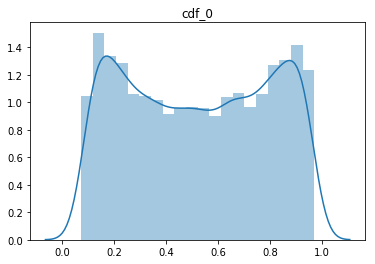

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


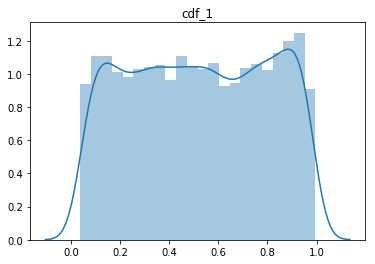

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


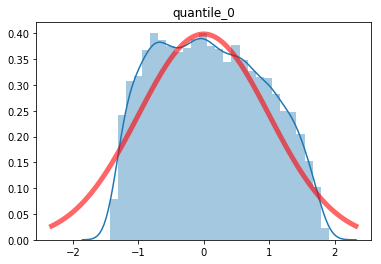

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


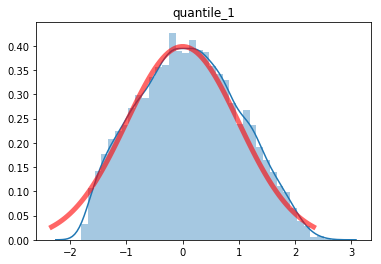

global step 601
loss: 4.2567034
cor:  [[[1.         0.69033307]
  [0.690333   1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


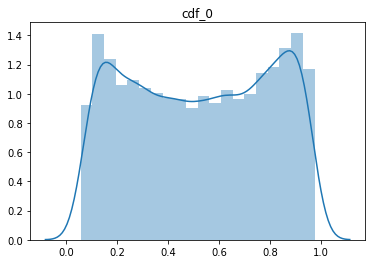

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


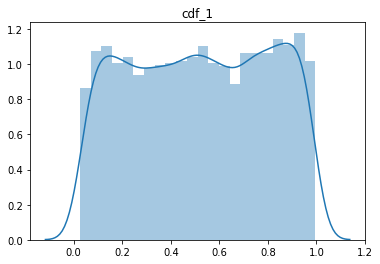

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


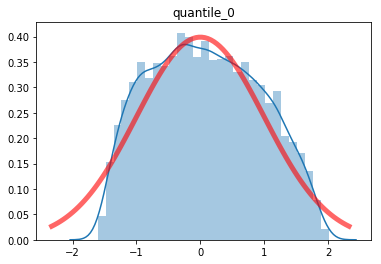

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


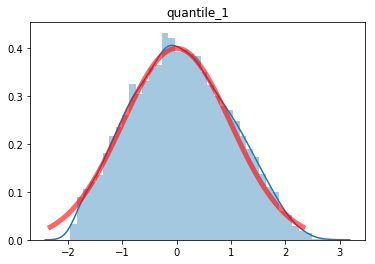

global step 701
loss: 4.22448
cor:  [[[1.        0.6873098]
  [0.6873098 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


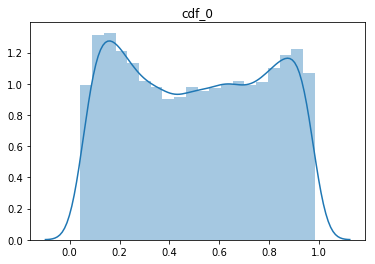

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


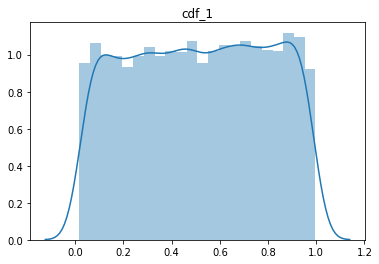

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


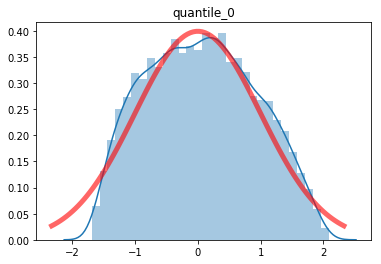

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


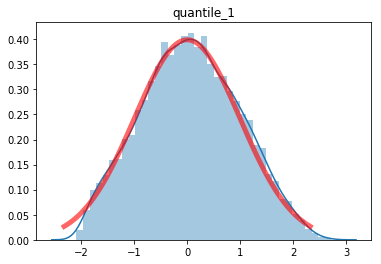

global step 801
loss: 4.190971
cor:  [[[1.         0.69394255]
  [0.69394255 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


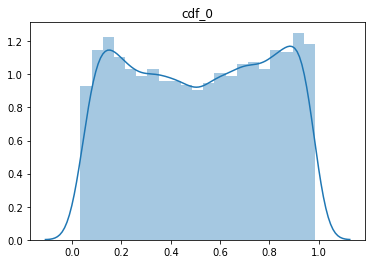

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


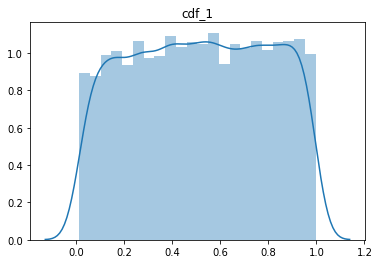

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


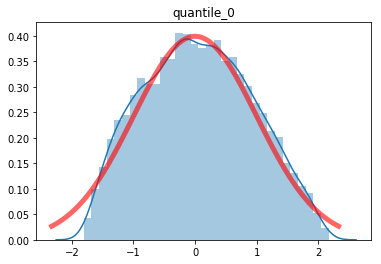

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


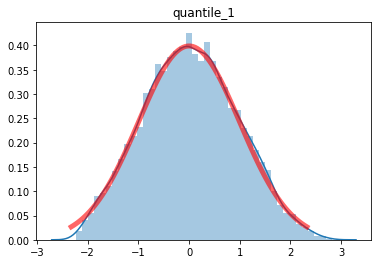

global step 901
loss: 4.1676416
cor:  [[[1.         0.7029403 ]
  [0.70294034 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


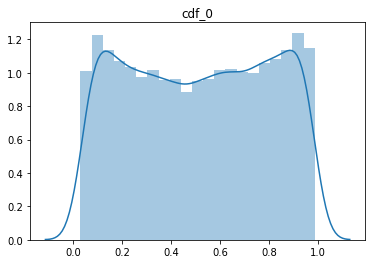

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


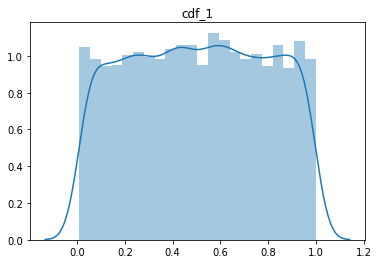

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


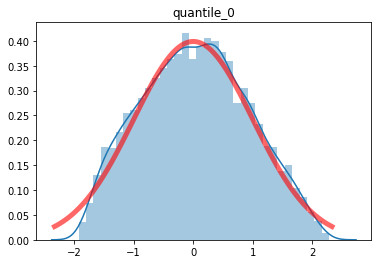

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


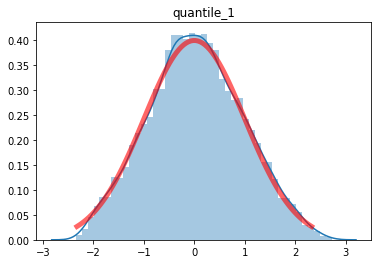

global step 1001
loss: 4.163278
cor:  [[[1.        0.6897414]
  [0.6897413 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


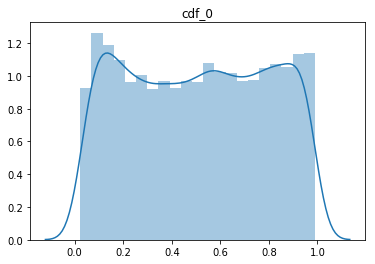

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


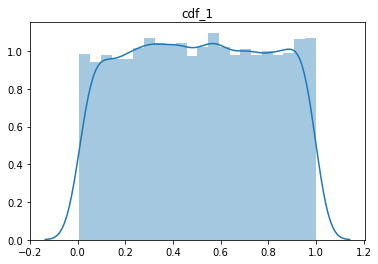

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


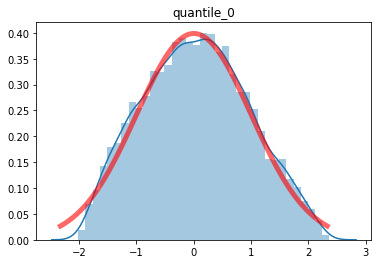

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


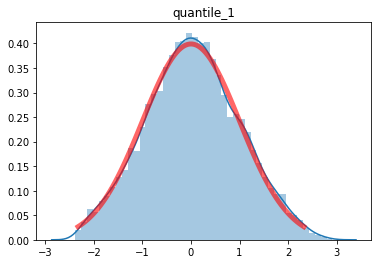

global step 1101
loss: 4.17005
cor:  [[[1.         0.69826275]
  [0.6982627  1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


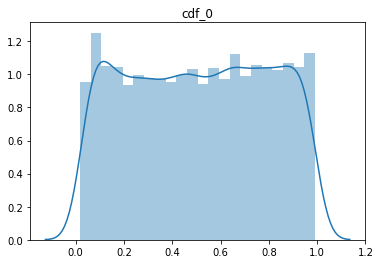

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


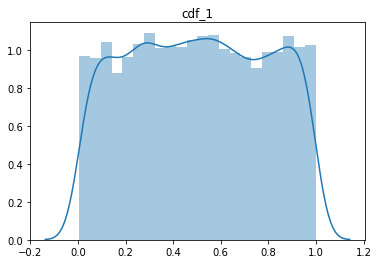

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


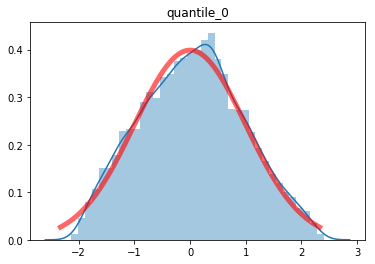

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


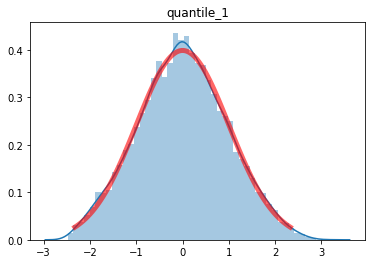

global step 1201
loss: 4.144493
cor:  [[[1.        0.7008888]
  [0.7008888 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


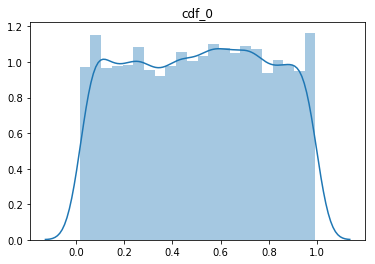

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


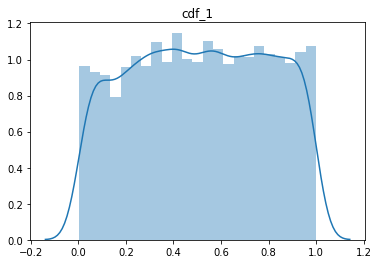

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


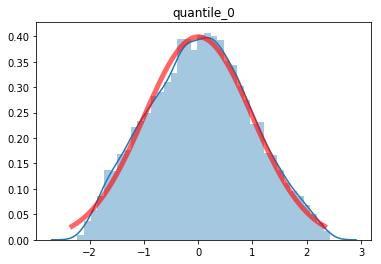

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


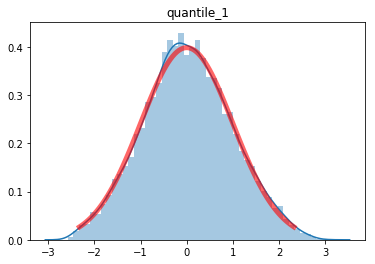

global step 1301
loss: 4.1544185
cor:  [[[1.        0.6946614]
  [0.6946614 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


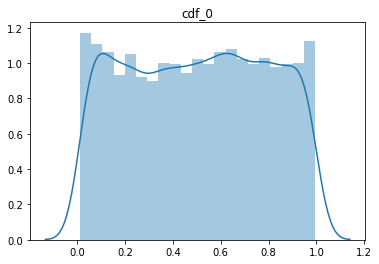

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


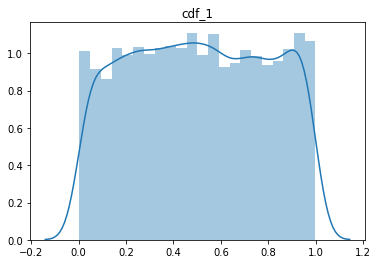

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


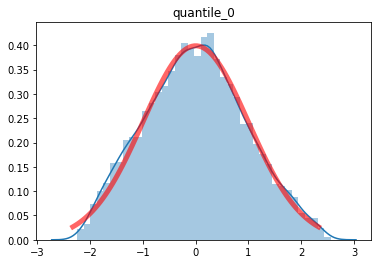

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


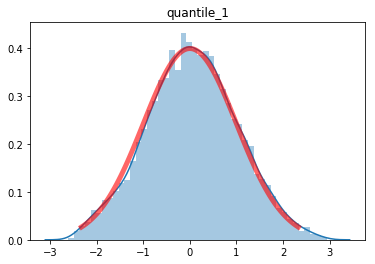

global step 1401
loss: 4.1379733
cor:  [[[1.         0.7056154 ]
  [0.70561534 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


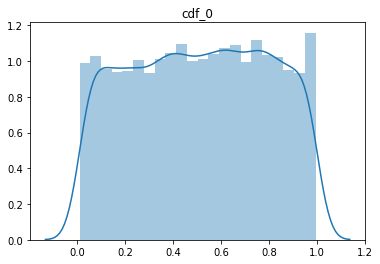

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


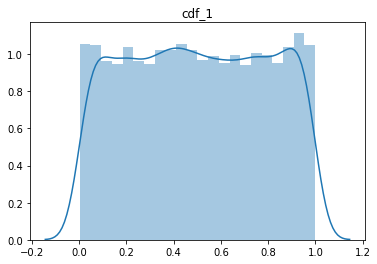

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


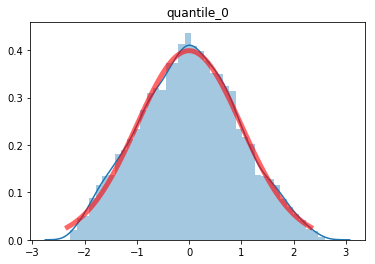

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


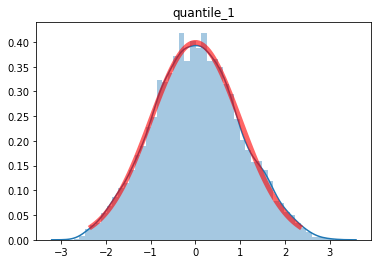

global step 1501
loss: 4.1253705
cor:  [[[1.        0.6957715]
  [0.6957716 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


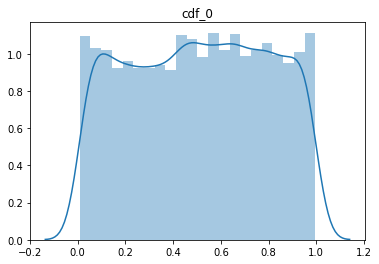

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


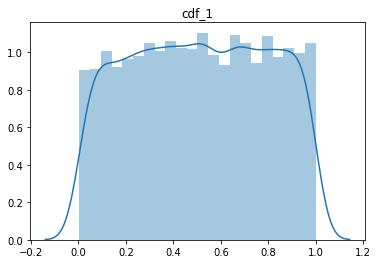

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


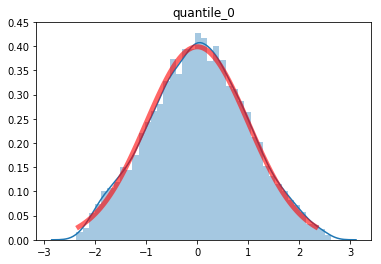

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


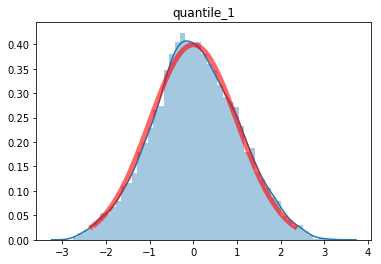

global step 1601
loss: 4.1363583
cor:  [[[1.        0.7012873]
  [0.7012874 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


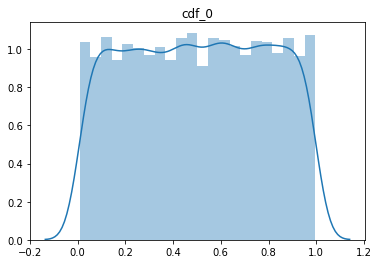

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


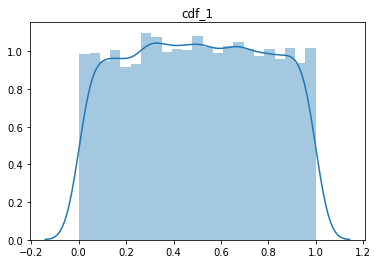

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


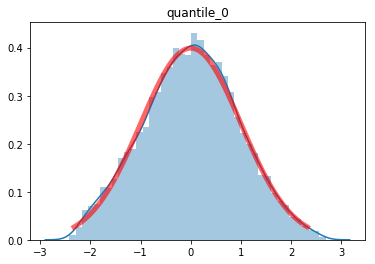

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


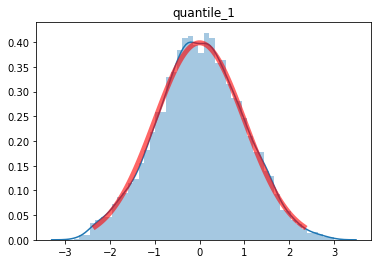

global step 1701
loss: 4.133747
cor:  [[[1.        0.6988069]
  [0.6988068 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


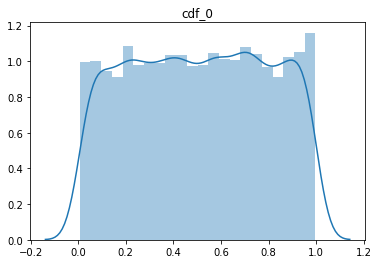

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


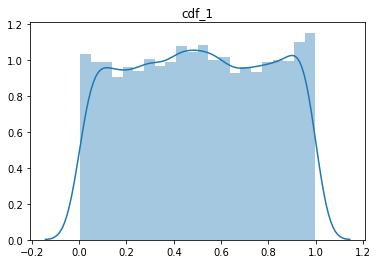

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


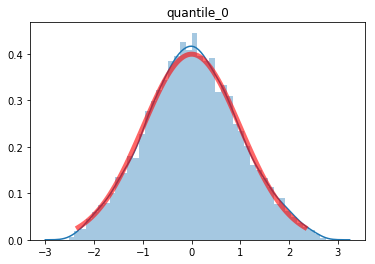

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


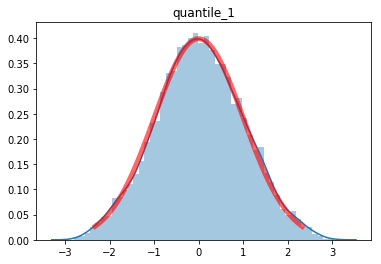

global step 1801
loss: 4.127475
cor:  [[[1.        0.7010013]
  [0.7010013 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


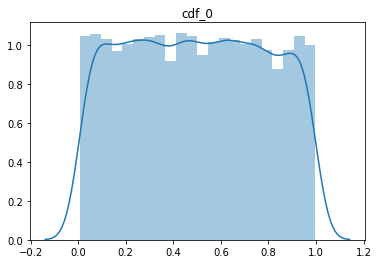

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


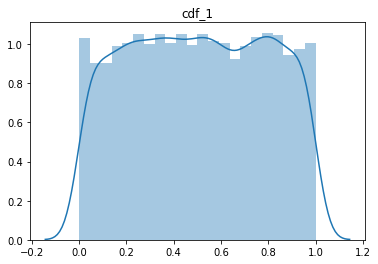

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


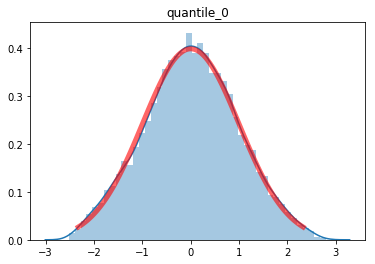

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


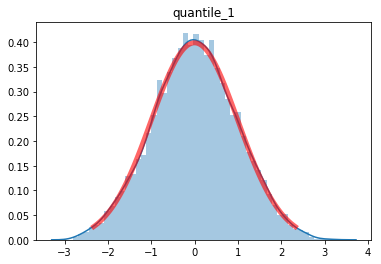

global step 1901
loss: 4.1361437
cor:  [[[1.         0.70075387]
  [0.70075387 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


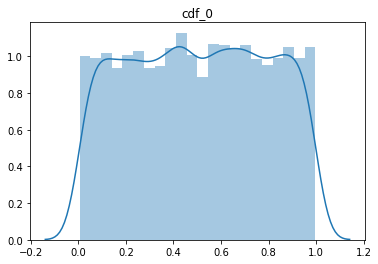

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


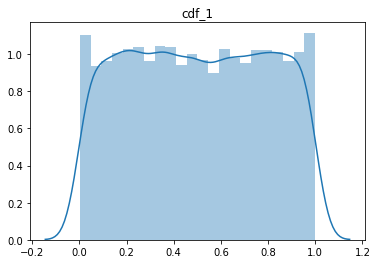

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


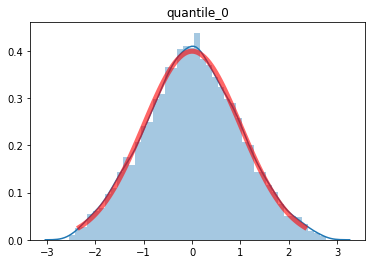

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


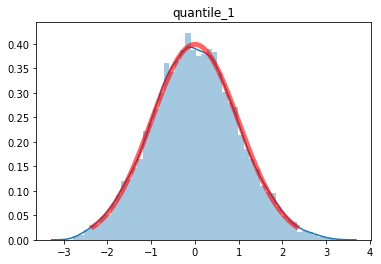

global step 2001
loss: 4.1352015
cor:  [[[1.         0.7107703 ]
  [0.71077037 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


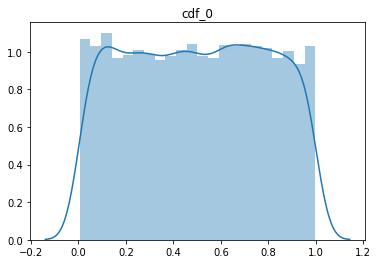

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


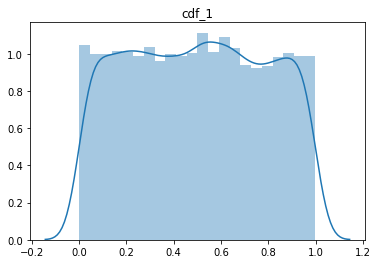

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


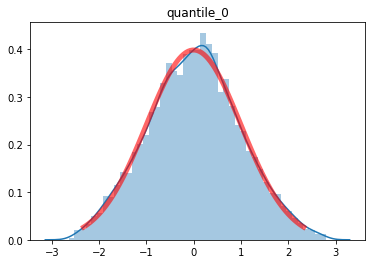

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


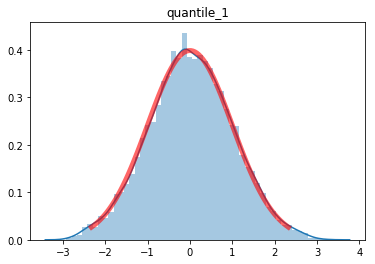

global step 2101
loss: 4.1287827
cor:  [[[1.        0.6969097]
  [0.6969097 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


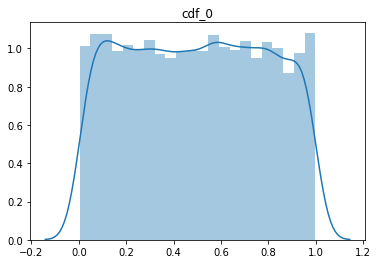

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


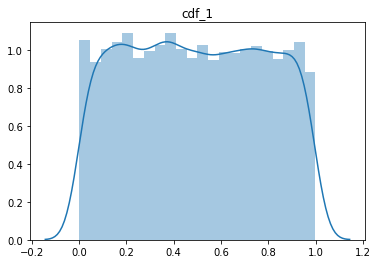

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


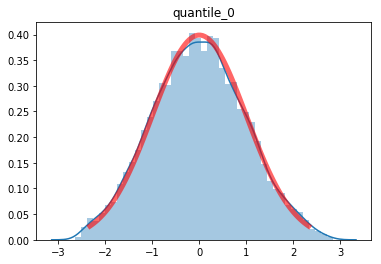

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


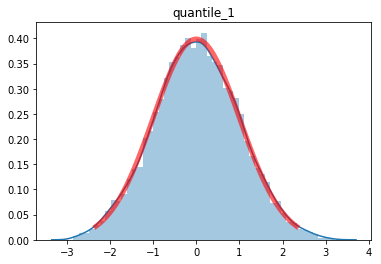

global step 2201
loss: 4.121047
cor:  [[[1.        0.6920945]
  [0.6920945 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


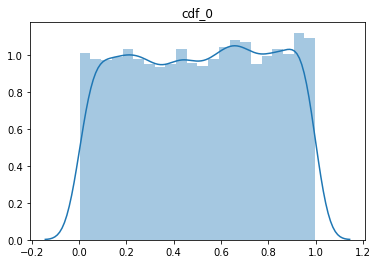

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


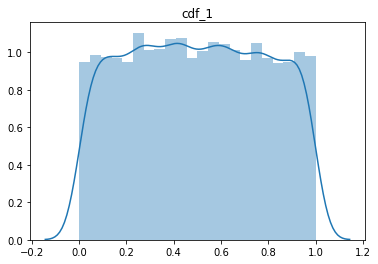

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


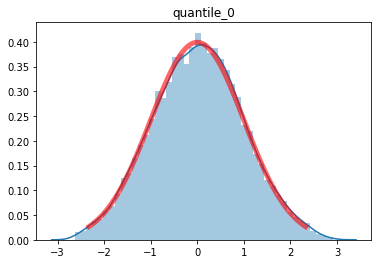

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


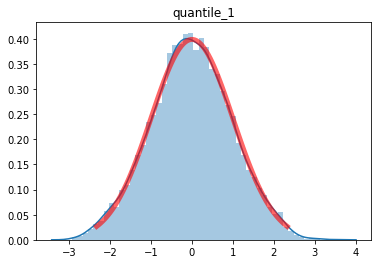

global step 2301
loss: 4.121974
cor:  [[[1.        0.6948441]
  [0.6948441 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


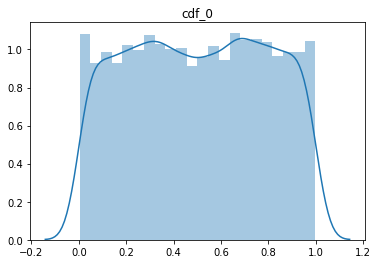

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


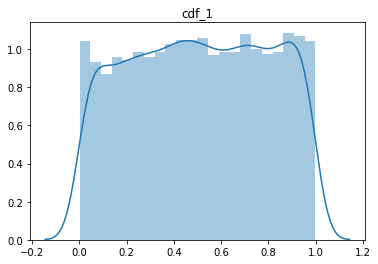

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


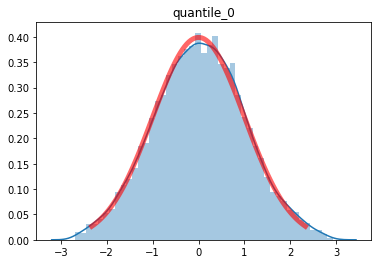

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


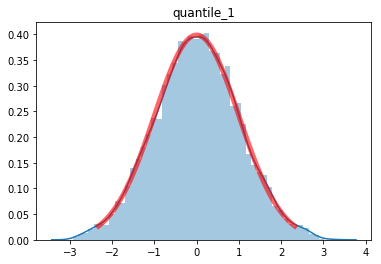

global step 2401
loss: 4.114449
cor:  [[[1.        0.6977922]
  [0.6977922 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


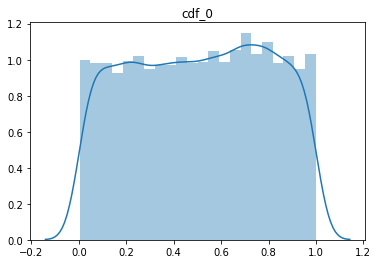

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


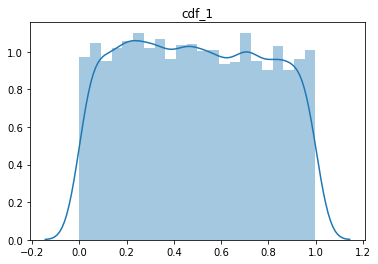

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


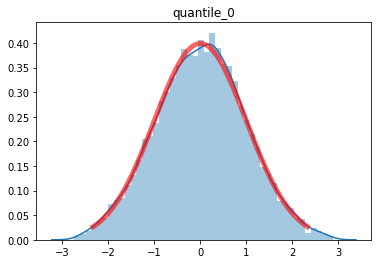

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


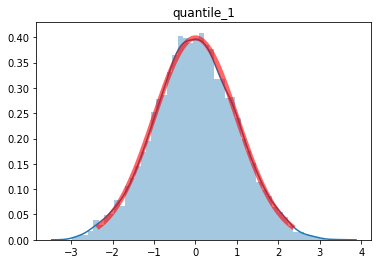

global step 2501
loss: 4.1125975
cor:  [[[1.         0.70218956]
  [0.7021896  1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


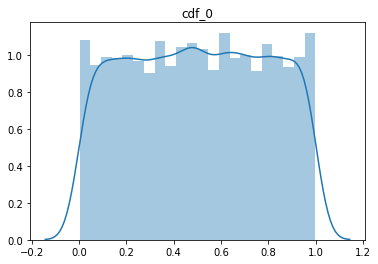

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


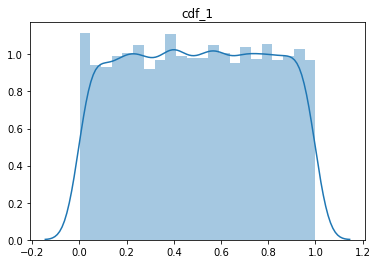

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


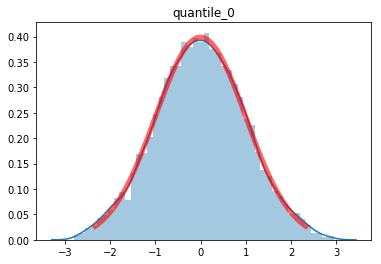

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


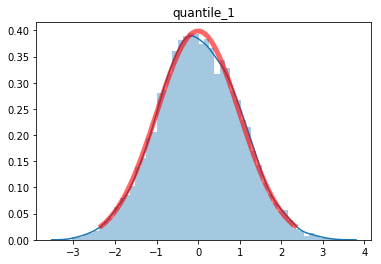

global step 2601
loss: 4.1009912
cor:  [[[1.        0.7046785]
  [0.7046785 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


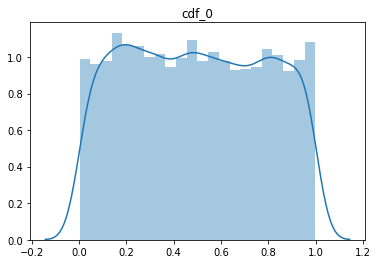

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


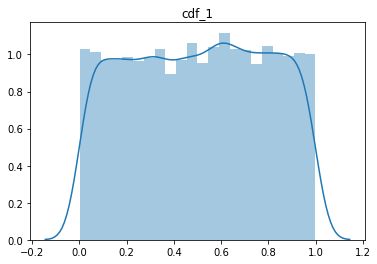

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


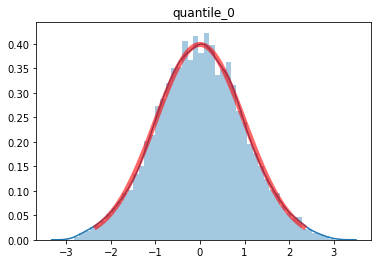

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


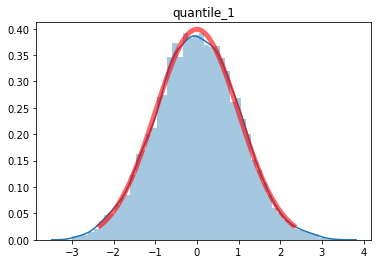

global step 2701
loss: 4.1139555
cor:  [[[1.         0.69616055]
  [0.69616055 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


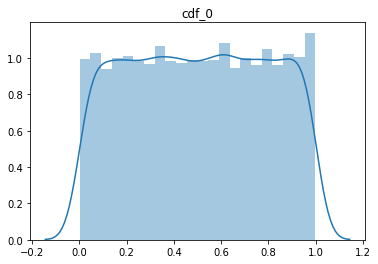

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


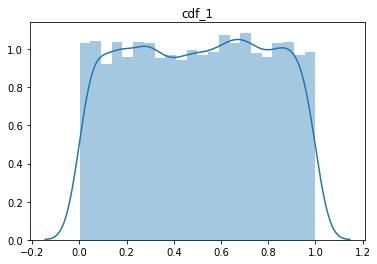

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


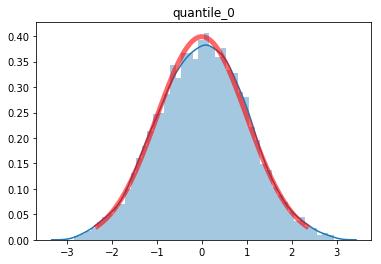

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


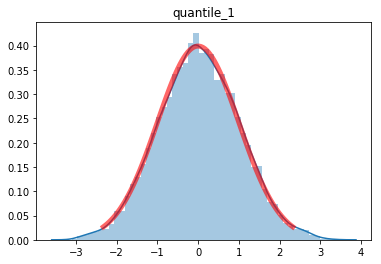

global step 2801
loss: 4.10733
cor:  [[[1.        0.7018732]
  [0.7018732 1.       ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


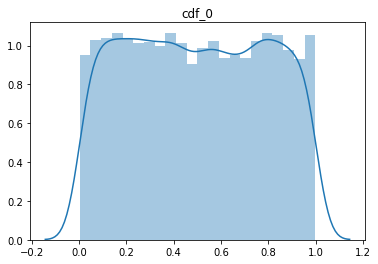

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


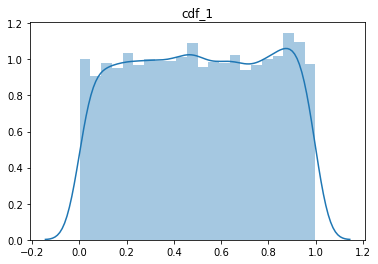

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


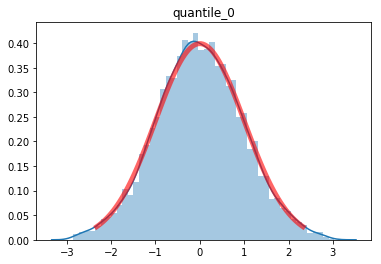

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


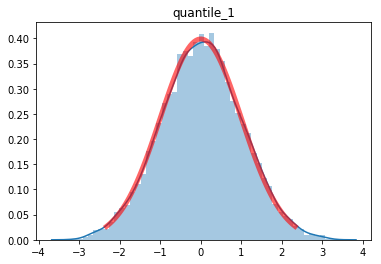

global step 2901
loss: 4.1093287
cor:  [[[1.         0.70664084]
  [0.70664084 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


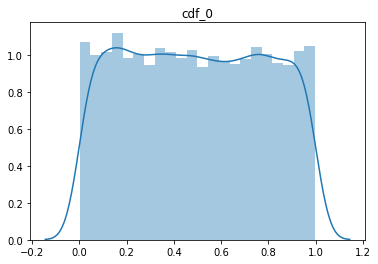

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


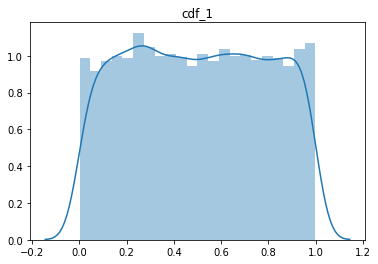

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


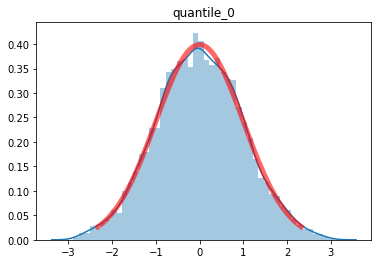

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


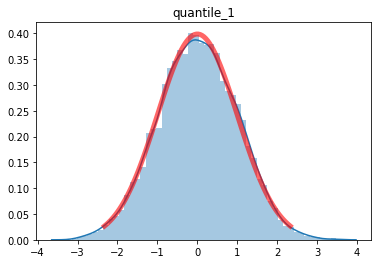

true_loss:  4.11789
loss:  4.1100087
cor:  [[[1.         0.71009076]
  [0.71009076 1.        ]]]


/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


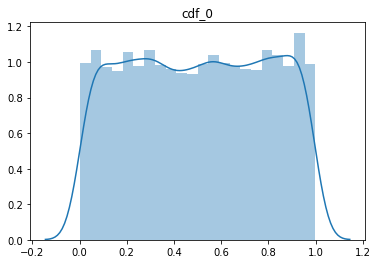

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


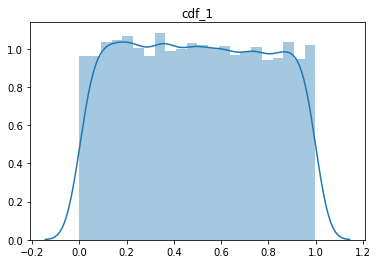

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


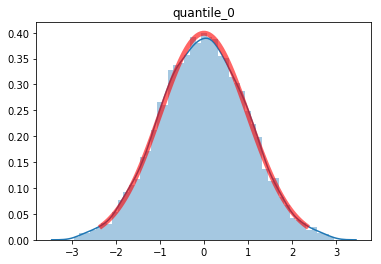

/home/pawel/tensorflow/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


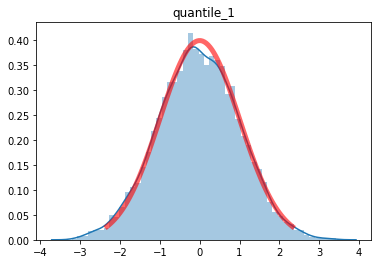

In [8]:
tf.reset_default_graph()
global_step_tensor = tf.Variable(0, trainable=False, name='global_step')
corr_coef = 0.7
corr_ = np.array([[1.0,corr_coef],[corr_coef,1.0]], dtype=np.float32)
std_dev = np.array([[1.0,0.0],[0,5.0]], dtype=np.float32)
true_cov = np.matmul(std_dev, np.matmul(corr_,std_dev))
print("true_cov: %s"%true_cov)

y_size = 2
samples = 10000

if y_size == 2:
    data_gen = tp.distributions.MultivariateNormalFullCovariance(loc=tf.constant([0.0] * 2),
                                                                 covariance_matrix=tf.constant(true_cov))
    sample_op = data_gen.sample([samples])
elif y_size==1:
    data_gen = tp.distributions.Normal(loc=tf.constant(0.0), scale=3.0)
    sample_op = tf.reshape(data_gen.sample([samples]), [-1,1])
else:
    raise ValueError("wrong size")
    

x_size, x, y = 0 ,None,sample_op
# tf.constant([[1.0]]*samples,dtype=tf.float32)

params={}
params['positive_transform'] = "square"
params['learning_rate'] = 0.001
# params['cov_type'] = "param_cov"
params['cov_type'] = "const_cov"
params['arch2'] = [5,5]
params['arch1'] = [5,5]
# params['arch_cov']=[5,5]
params['activation'] = "tanh"


positive_transform = params['positive_transform']
learning_rate = params["learning_rate"]
cov_type = params["cov_type"]

x_transform = transform_x(params, x)


cdfs, pdfs = density_estimator(params, positive_transform, x_transform, y, y_size)


predictions = marginals_and_joint(cov_type, cdfs, pdfs, x, params)

loss = tf.negative(tf.reduce_mean(predictions["log_likelihood"]), name="loss")
true_loss = tf.negative(tf.reduce_mean(data_gen.log_prob(sample_op)), name="loss_true")

adam = tf.train.AdamOptimizer(learning_rate=0.001)

joint_train_op = adam.minimize(loss, global_step=tf.train.get_global_step())

# train = adam.minimize(loss, global_step=tf.train.get_global_step())
def train_loop(iters, tain_op):
    print("global step %d"%session.run(tf.train.get_global_step()))
    
    print("true_loss: ",session.run(true_loss))
    print("loss: ",session.run(loss))
#     , options=tf.RunOptions(report_tensor_allocations_upon_oom =True)
    if "cor" in predictions:
        print("cor: ",session.run(predictions["cor"]))
    
    for i,cdf in enumerate(cdfs):
        plt.figure();
        sns.distplot(session.run(cdf));
        plt.title("cdf_%d"%i)
        plt.show();
        
    for i,cdf in enumerate(cdfs):     
        fig,ax=plt.subplots(1,1);
        sns.distplot(session.run(predictions["quantile_%d"%i]),ax=ax);
        ax.plot(x_norm,pdf_norm,'r-',lw=5,alpha=0.6,label='norml pdf')
        plt.title("quantile_%d"%i)
        
        plt.show();
    
    for step in range(iters):  
        session.run(tain_op)
        if step%100 == 0:
            print("global step %d"%session.run(tf.train.get_global_step()))
            print("loss:", session.run(loss))
            if "cor" in predictions:
                print("cor: ",session.run(predictions["cor"]))
            for i,cdf in enumerate(cdfs):
                plt.figure();
                sns.distplot(session.run(cdf));
                plt.title("cdf_%d"%i)
                plt.show();
                     
            for i,cdf in enumerate(cdfs):   
                fig,ax=plt.subplots(1,1);
                sns.distplot(session.run(predictions["quantile_%d"%i]),ax=ax);
                ax.plot(x_norm,pdf_norm,'r-',lw=5,alpha=0.6,label='norml pdf')
                plt.title("quantile_%d"%i)
                     
                plt.show();
            
    print("true_loss: ",session.run(true_loss))
    print("loss: ",session.run(loss))
    if "cor" in predictions:
        print("cor: ",session.run(predictions["cor"]))
    for i,cdf in enumerate(cdfs):
        plt.figure();
        sns.distplot(session.run(cdf));
        plt.title("cdf_%d"%i)
        plt.show();
        
    for i,cdf in enumerate(cdfs):    
        fig,ax=plt.subplots(1,1);
        sns.distplot(session.run(predictions["quantile_%d"%i]),ax=ax);
        ax.plot(x_norm,pdf_norm,'r-',lw=5,alpha=0.6,label='norml pdf')
        plt.title("quantile_%d"%i)
                             
        plt.show();
        

with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=float(FLAGS.per_process_gpu_memory_fraction)))) as session:
    session.run(tf.global_variables_initializer())
#     train_loop(1000, marginals_train_op)
#     train_loop(1000, copula_train_op)
    train_loop(3000, joint_train_op)
#     res=session.run(ll)